In [259]:
from kafka import KafkaConsumer
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm.auto as tqdm

**Get data with kafka Consumer**

In [260]:
# Kafka consumer configuration
# ssh -L 9092:localhost:9092 tunnel@128.2.204.215 -NT

topic_name = "movielog25"  # Replace N with your actual team number
bootstrap_servers = ['localhost:9092']

# Initialize Kafka consumer
consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=bootstrap_servers,
    auto_offset_reset='earliest',  # Start reading at the earliest message
    group_id=None,  # Do not commit offsets
)

In [276]:
from kafka import TopicPartition
# Initialize Kafka consumer
consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=bootstrap_servers,
    auto_offset_reset='earliest',  # Start reading at the earliest message
    group_id=None,  # Do not commit offsets
)
# Fetch all partitions for the topic
partitions = consumer.partitions_for_topic(topic_name)
if partitions is None:
    raise Exception(f"Topic {topic_name} not found.")

topic_partitions = [TopicPartition(topic_name, p) for p in partitions]

total_length = 0
# Calculate the total length of the stream
for tp in topic_partitions:
    consumer.seek_to_beginning(tp)
    earliest_offset = consumer.position(tp)
    consumer.seek_to_end(tp)
    latest_offset = consumer.position(tp)

    length = latest_offset - earliest_offset
    total_length += length

consumer.close()
print("total_length:", total_length)

total_length: 72342196


In [277]:
# Initialize Kafka consumer
consumer = KafkaConsumer(
    topic_name,
    bootstrap_servers=bootstrap_servers,
    auto_offset_reset='earliest',  # Start reading at the earliest message
    group_id=None,  # Do not commit offsets
)
max_messages = 72281118//10
messages = []
for message in consumer:
    if len(messages) > max_messages:
        break
    if len(messages)<10: #show sample 10 consumer message
        print(message)
    text = message.value.decode("utf-8")
    
    messages.append(text)
consumer.close()


ConsumerRecord(topic='movielog25', partition=0, offset=0, timestamp=1707168126953, timestamp_type=0, key=None, value=b'2023-12-27T17:23:10,99788,GET /data/m/the+brothers+2001/0.mpg', headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=61, serialized_header_size=-1)
ConsumerRecord(topic='movielog25', partition=0, offset=1, timestamp=1707168126963, timestamp_type=0, key=None, value=b'2023-12-27T17:25:13,99788,GET /data/m/the+brothers+2001/2.mpg', headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=61, serialized_header_size=-1)
ConsumerRecord(topic='movielog25', partition=0, offset=2, timestamp=1707168126964, timestamp_type=0, key=None, value=b'2023-12-27T17:27:19,99788,GET /data/m/the+brothers+2001/4.mpg', headers=[], checksum=None, serialized_key_size=-1, serialized_value_size=61, serialized_header_size=-1)
ConsumerRecord(topic='movielog25', partition=0, offset=3, timestamp=1707168126965, timestamp_type=0, key=None, value=b'2023-12-27T17:29:19,

**Parse messages to get movie user ratings**

In [278]:
def parse_consumer(text):
    #2023-12-27T17:23:10,99788,GET /data/m/the+brothers+2001/0.mpg -------streaming history
    #2023-12-27T19:10:59,160766,GET /rate/the+tigger+movie+2000=4 --------rating score

    components = text.split(',')
    timestamp = components[0]
    user_id = components[1]
    
    movie_part=np.nan
    movie_score=np.nan
    if '=' not in text: #streaming history
        #GET /data/m/the+brothers+2001/0.mpg"
        
        movie_path = components[2].split('/')
        movie_name_id = movie_path[3].replace('+', '_')
        movie_part = int(movie_path[4].split('.')[0])
    else: #rating score
        #GET /rate/the+tigger+movie+2000=4
        movie_path = components[2].split('/')
        detail = movie_path[2].split('=')
        movie_name_id = detail[0].replace('+', '_')
        movie_score = int(detail[1])

    
    return user_id, movie_name_id, movie_part, movie_score
    


In [279]:
data = map(parse_consumer, messages)
df_raw = pd.DataFrame(data,columns = ['user_id', 'movie_name_id', 'movie_part','movie_score'])
df_raw

,user_id,movie_name_id,movie_part,movie_score
0,99788,the_brothers_2001,0.0,NaN
1,99788,the_brothers_2001,2.0,NaN
2,99788,the_brothers_2001,4.0,NaN
3,99788,the_brothers_2001,6.0,NaN
4,99788,the_brothers_2001,8.0,NaN
...,...,...,...,...
7228107,43555,apollo_13_1995,119.0,NaN
7228108,180321,the_shawshank_redemption_1994,128.0,NaN
7228109,190314,the_lord_of_the_rings_1978,17.0,NaN
7228110,106233,executive_decision_1996,62.0,NaN


**Get each user's longest watching time of the movie**

In [290]:
df=df_raw.groupby(['user_id','movie_name_id']).max().reset_index() #take the last part of the movie the user watched through
df

,user_id,movie_name_id,movie_part,movie_score
0,100020,an_american_werewolf_in_paris_1997,106.0,2.0
1,100020,batman_returns_1992,127.0,3.0
2,100020,blade_1998,121.0,4.0
3,100020,boys_and_girls_2000,4.0,3.0
4,100020,con_air_1997,116.0,4.0
...,...,...,...,...
63831,9998,star_wars_episode_iii_-_revenge_of_the_sith_2005,141.0,NaN
63832,9998,the_cell_2000,108.0,2.0
63833,9998,the_lord_of_the_rings_the_return_of_the_king_2003,202.0,5.0
63834,9998,titan_a.e._2000,36.0,2.0


<AxesSubplot:>

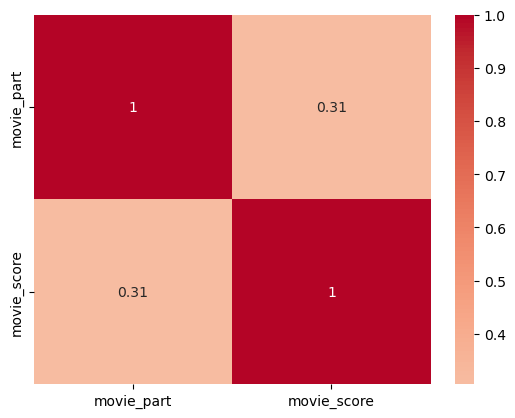

In [294]:
import seaborn as sns
sns.heatmap(df[['movie_part','movie_score']].corr(), annot=True, cmap='coolwarm', center=0)

**Turn watching time to ratings**

In [281]:
def calc_score(x):
    if x>100:
        return 5.0
    return x/20
df['movie_score'] = df.apply(lambda x: calc_score(x['movie_part']) if pd.isnull(x['movie_score']) else x['movie_score'], axis=1)
df.head()
# df = df.dropna()

,user_id,movie_name_id,movie_part,movie_score
0,100020,an_american_werewolf_in_paris_1997,106.0,2.0
1,100020,batman_returns_1992,127.0,3.0
2,100020,blade_1998,121.0,4.0
3,100020,boys_and_girls_2000,4.0,3.0
4,100020,con_air_1997,116.0,4.0


In [282]:
X=df[['user_id','movie_name_id','movie_score']]
X

,user_id,movie_name_id,movie_score
0,100020,an_american_werewolf_in_paris_1997,2.0
1,100020,batman_returns_1992,3.0
2,100020,blade_1998,4.0
3,100020,boys_and_girls_2000,3.0
4,100020,con_air_1997,4.0
...,...,...,...
63831,9998,star_wars_episode_iii_-_revenge_of_the_sith_2005,5.0
63832,9998,the_cell_2000,2.0
63833,9998,the_lord_of_the_rings_the_return_of_the_king_2003,5.0
63834,9998,titan_a.e._2000,2.0


**Visualize Matrix**

In [305]:
#view user item rating matrix
df_matrix = X.pivot(index='user_id', columns='movie_name_id', values='movie_score').fillna(0)
print("Number of nonzeros:",np.count_nonzero(df_matrix.values), "out of", df_matrix.shape[0]*df_matrix.shape[1],"percentage", np.count_nonzero(df_matrix.values)/(df_matrix.shape[0]*df_matrix.shape[1]))
print("user numbers,",np.unique(X['user_id'].values).shape[0], "movie numbers,", np.unique(X['movie_name_id'].values).shape[0])

df_matrix

Number of nonzeros: 63836 out of 24154976 percentage 0.0026427680987967032
user numbers, 4217 movie numbers, 5728


movie_name_id,...all_the_marbles_1981,...and_justice_for_all_1979,1-900_1994,100_feet_2008,100_girls_2000,101_dalmatians_1996,102_dalmatians_2000,10_000_bc_2008,10_1979,10_items_or_less_2006,...,zero_dark_thirty_2012,zero_effect_1998,zeus__roxanne_1997,ziggy__stardust_and_the_spiders_from_mars_1973,zodiac_2007,zombie_strippers_2008,zombieland_2009,zoolander_2001,zorro__the_gay_blade_1981,zulu_1964
user_id,,,,,,,,,,,,,,,,,,,,,
100020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100085,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100248,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Build models**

In [306]:
from surprise import NMF, SVD, SVDpp, KNNWithMeans, CoClustering,BaselineOnly, NormalPredictor,Dataset, Reader
from surprise.model_selection import cross_validate
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(X[['user_id', 'movie_name_id', 'movie_score']], reader)

In [307]:
normal = NormalPredictor()
results = cross_validate(normal, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm NormalPredictor on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.4854  1.4812  1.4791  1.4893  1.4931  1.4856  0.0051  
MAE (testset)     1.1662  1.1560  1.1561  1.1736  1.1693  1.1642  0.0071  
Fit time          0.04    0.05    0.05    0.04    0.04    0.04    0.00    
Test time         0.05    0.05    0.05    0.05    0.05    0.05    0.00    


In [308]:
baseline = BaselineOnly(verbose=False)
results = cross_validate(baseline, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0661  1.0692  1.0653  1.0801  1.0663  1.0694  0.0055  
MAE (testset)     0.8607  0.8622  0.8586  0.8657  0.8590  0.8612  0.0026  
Fit time          0.05    0.04    0.05    0.05    0.05    0.05    0.00    
Test time         0.04    0.03    0.19    0.03    0.03    0.07    0.06    


In [309]:
nmf = NMF(n_factors=30, biased=True, n_epochs=50, lr_bu=0.001,lr_bi=0.001,  verbose=False)
results = cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0955  1.0878  1.0951  1.1024  1.1134  1.0988  0.0086  
MAE (testset)     0.8753  0.8659  0.8689  0.8755  0.8843  0.8740  0.0064  
Fit time          1.18    1.15    1.16    1.24    1.13    1.17    0.04    
Test time         0.05    0.21    0.05    0.05    0.05    0.08    0.07    


In [310]:
svd= SVD(n_factors=30, n_epochs=50, lr_all=0.005, reg_all=0.05, verbose=False)
results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0890  1.0972  1.1001  1.0930  1.0902  1.0939  0.0042  
MAE (testset)     0.8656  0.8716  0.8792  0.8721  0.8679  0.8713  0.0046  
Fit time          0.40    0.46    0.43    0.39    0.43    0.42    0.02    
Test time         0.05    0.05    0.06    0.24    0.05    0.09    0.07    


In [311]:
knn= KNNWithMeans(k=100, min_k=10,verbose=False)
results = cross_validate(knn, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.1177  1.1215  1.1256  1.1256  1.1182  1.1217  0.0034  
MAE (testset)     0.8822  0.8915  0.8884  0.8906  0.8860  0.8877  0.0034  
Fit time          0.33    0.37    0.30    0.38    0.40    0.35    0.04    
Test time         0.77    0.73    1.20    0.81    0.72    0.84    0.18    
